In [2]:
import warnings
from helper import *
import tensorflow as tf
from math import ceil

In [3]:
# basic configuration
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 500)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# get the data files and their paths
file_dict, file_dir, master_dir = get_data_files()

In [5]:
# initialize the master dataframe to store all the data
master_df = pd.DataFrame()

In [6]:
# get the file indexes
available_file_indexes = get_file_indexes(file_dict=file_dict)

In [7]:
# years to be considered for the forecast
selected_years = [2021, 2022, 2023]

In [8]:
# get file names for the given year(s)
file_dict_given_years = create_file_dict(file_dict=file_dict, years=selected_years)

In [9]:
# find the top 20 pipes for every file
for year, files in file_dict_given_years.items():
    access_index = 0
    for index in available_file_indexes[year]:
        master_df = find_common_pipes(file_index=access_index, file_year=year,
                                      top_level_df=master_df, file_dict=file_dict,
                                      master_dir=master_dir, threshold=50)
        access_index += 1

In [10]:
# create dataframe contains pipe production data for every week and write them to Excel files
exp_df, exp_df_th = create_transposed_and_unique_df(master_df=master_df,
                                                    sheet_names=["General", "Experimental"],
                                                    file_dir=file_dir)

In [11]:
# format the Excel files
format_general_sheet(file_dir=file_dir)
format_experimental_sheet(file_dir=file_dir)

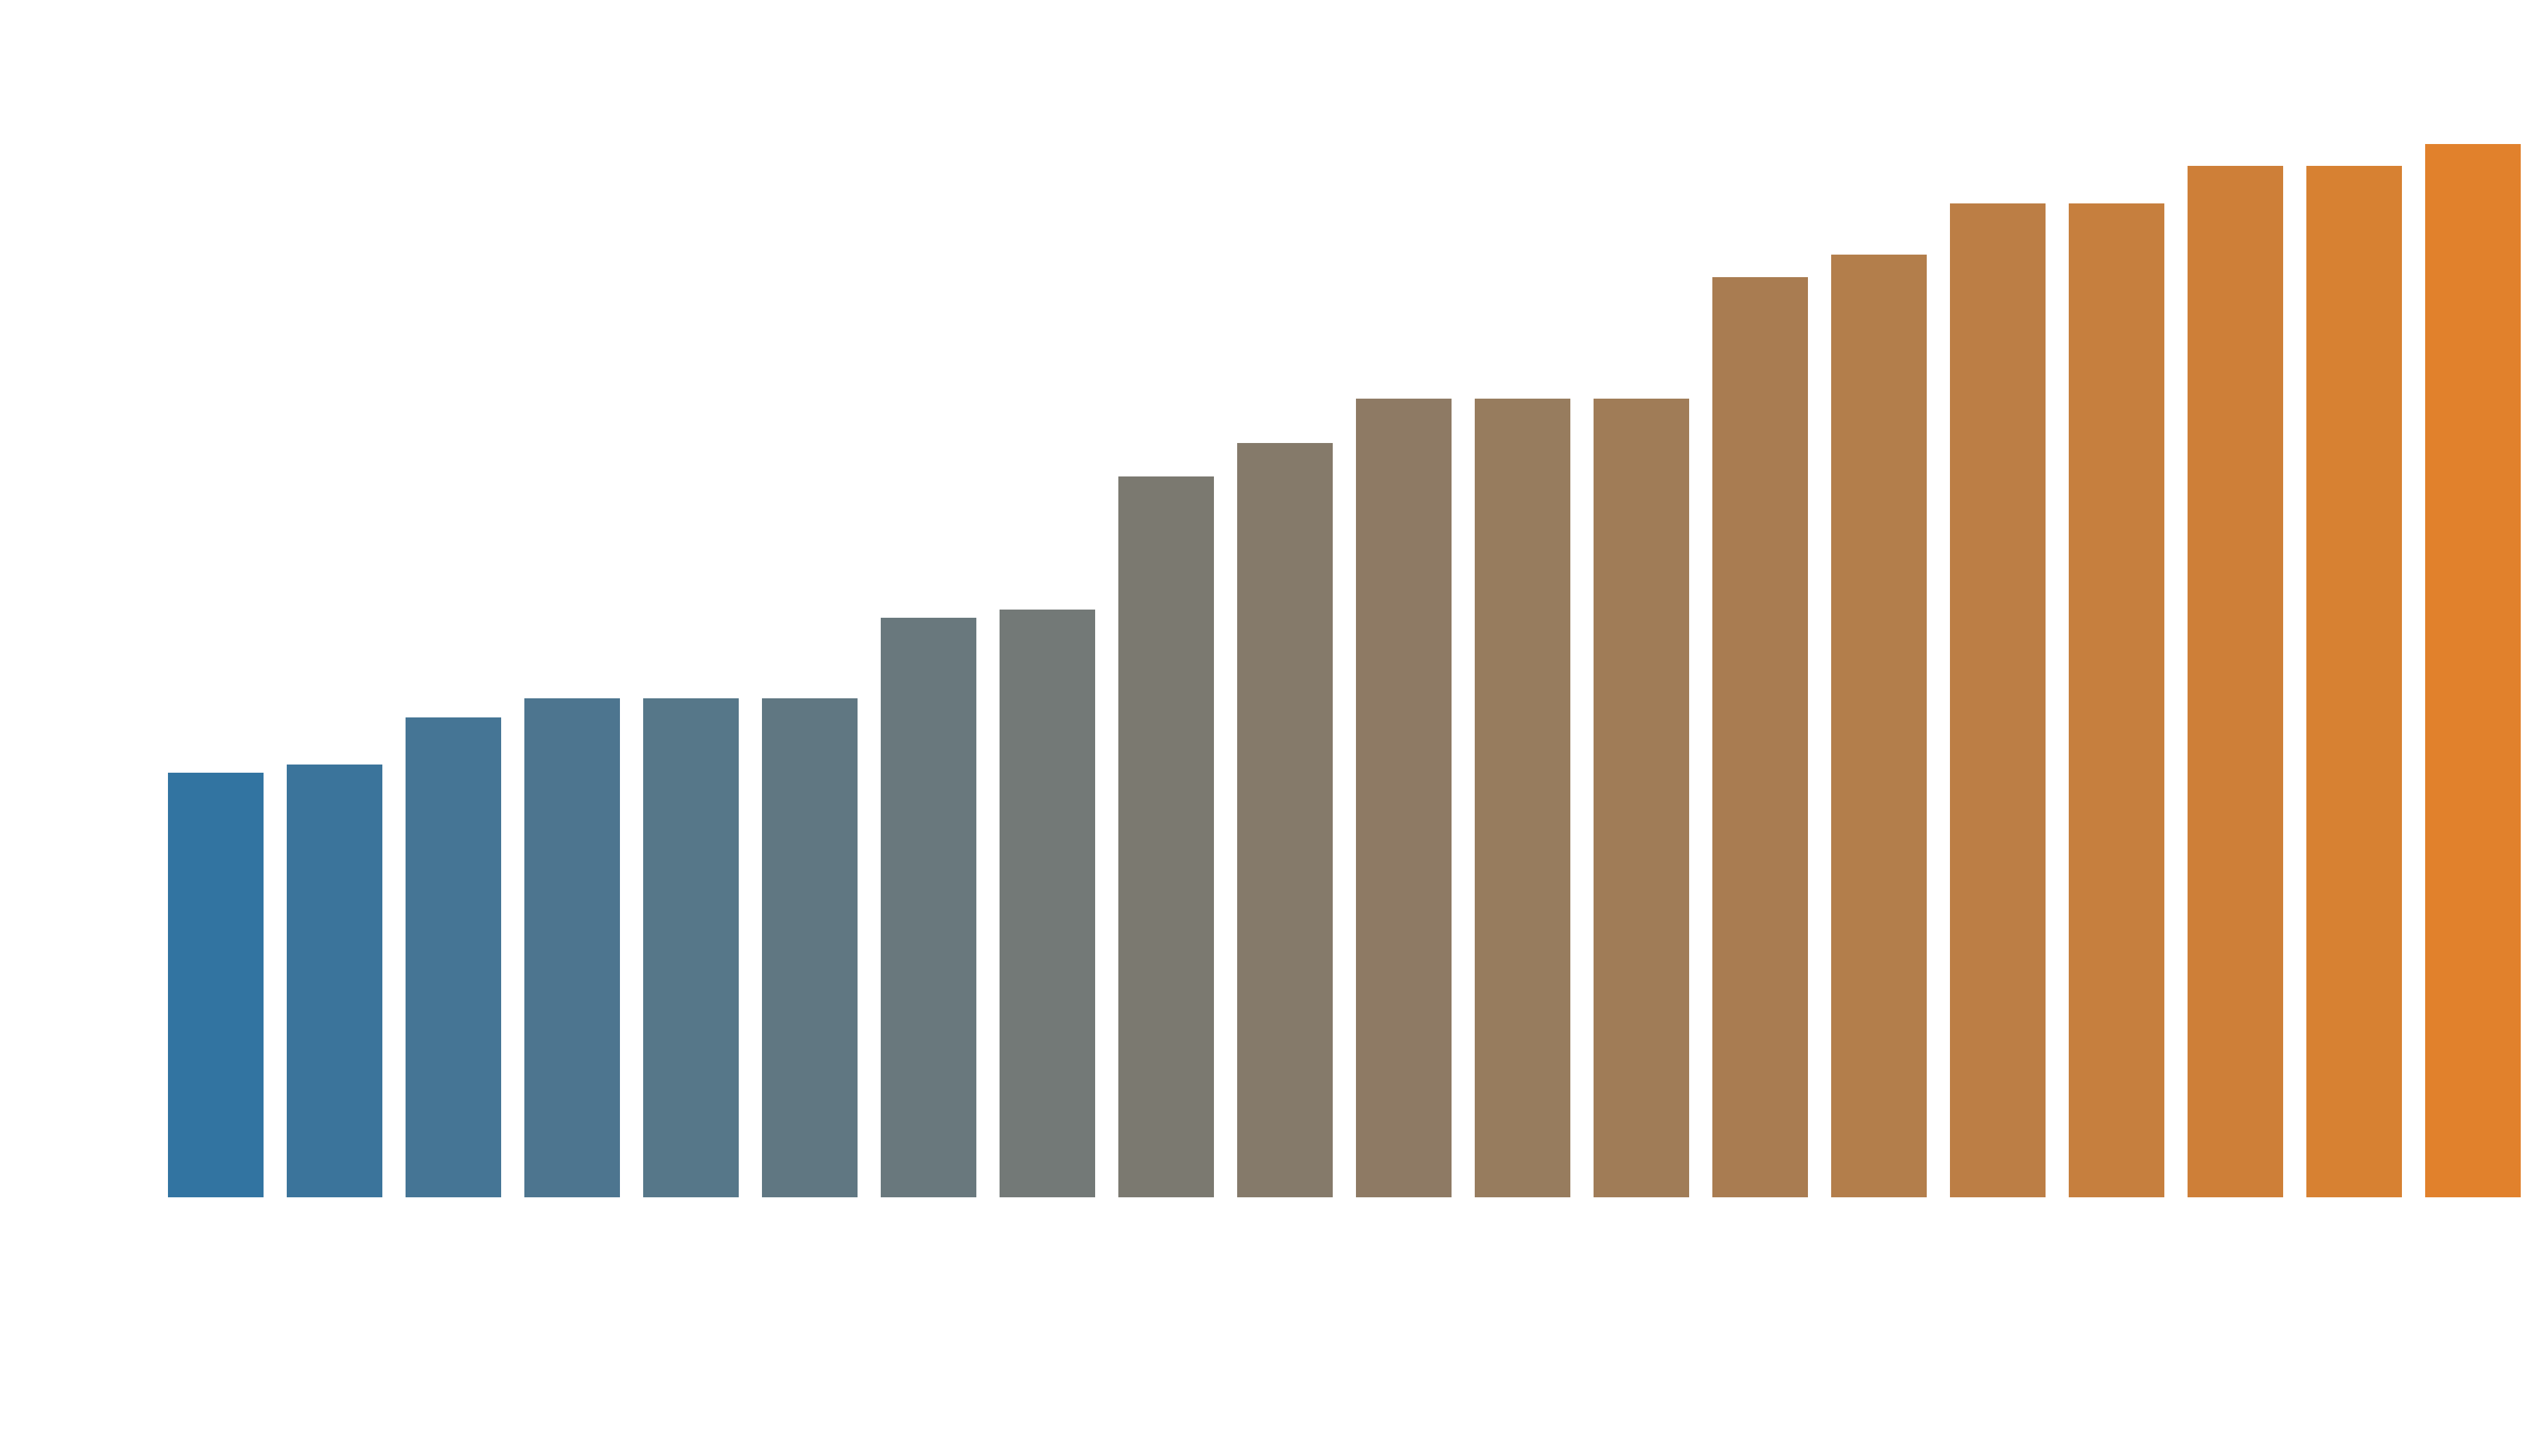

In [12]:
# plot the most popular 20 pipes for a specific week
# create_bar_plot(df=exp_df_th,
#                 selected_year=2022,
#                 file_index="34",
#                 ascending=True,
#                 threshold=20)

In [13]:
# create a unique dataframe that contains all the data (2021-2023)
final_df = create_unique_df(df=exp_df)

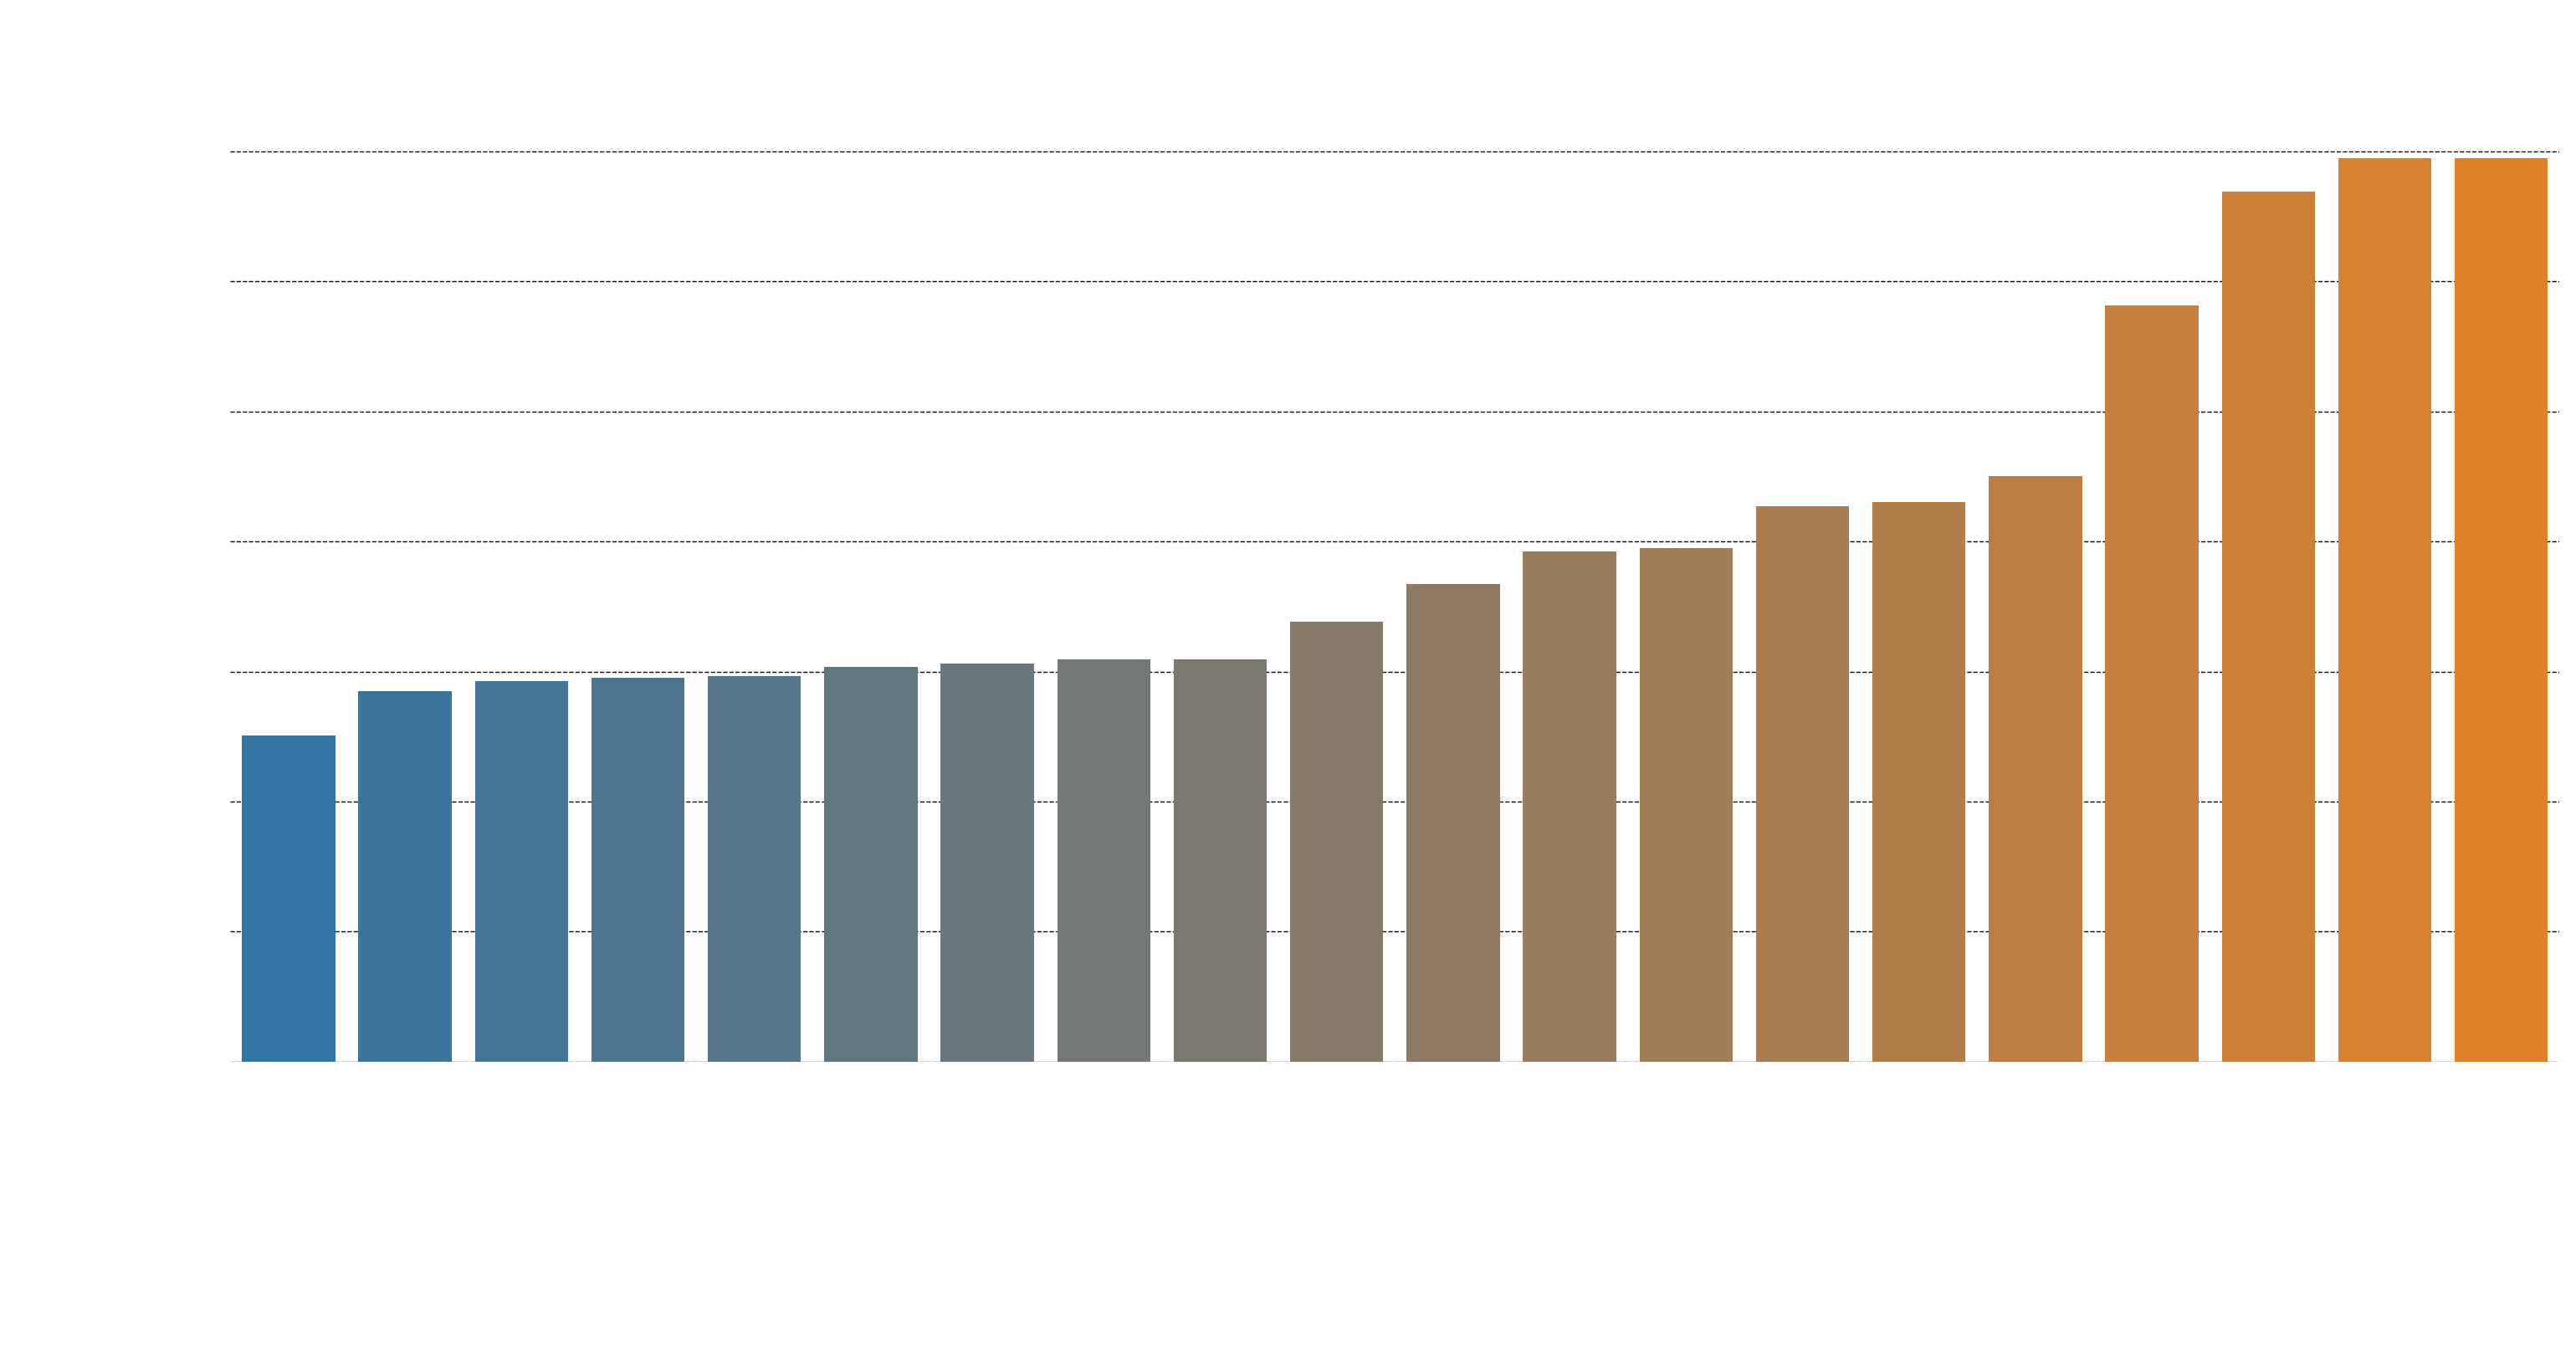

In [14]:
# plot the most popular 20 pipes for all the weeks (2021-2023)
# unique_pipe_bar_plot(pipe_df=final_df,
#                      total_quantity_limit=50000,
#                      fig_size=(16, 7),
#                      rotation='vertical',
#                      ascending=True,
#                      years=[2022, 2023])

In [15]:
# get the occurrences per file
pipe_occurrences_df = get_occurrences_per_file(df=exp_df)

In [16]:
# get the files with a given threshold of occurrences
pipes_in_threshold_df = get_occurrences_with_threshold(df=pipe_occurrences_df, threshold=50)

In [17]:
# filter the dataframe with the top 20 pipes
top_20_pipes = pipe_occurrences_df.iloc[:, 0].head(20)
top_20_pipes_df = list(map(int, pipe_occurrences_df[pipe_occurrences_df.iloc[:, 0].isin(top_20_pipes)].index))

In [18]:
# combine all the files satisfying the threshold for the popular pipes
all_in_one = combine_all_files_within_threshold(
    file_dict=file_dict_given_years, master_dir=master_dir, threshold_df=top_20_pipes_df)
all_in_one_T = convert_multi_to_single_df(df=all_in_one)

In [19]:
all_in_one_T = all_in_one_T.sort_index(inplace=False)

In [20]:
# reindex the all_in_one_T (start from 2022-01-06) and add 7 days for each row
filled_df = all_in_one_T.copy()
if selected_years == [2021, 2022, 2023]:
    filled_df.index = pd.date_range(start='2021-06-23', periods=len(all_in_one_T), freq='W')
elif selected_years == [2022, 2023]:
    filled_df.index = pd.date_range(start='2022-01-06', periods=len(all_in_one_T), freq='W')

# # convert the index column to datetime
filled_df.index = filled_df.index.astype('datetime64[ns]')

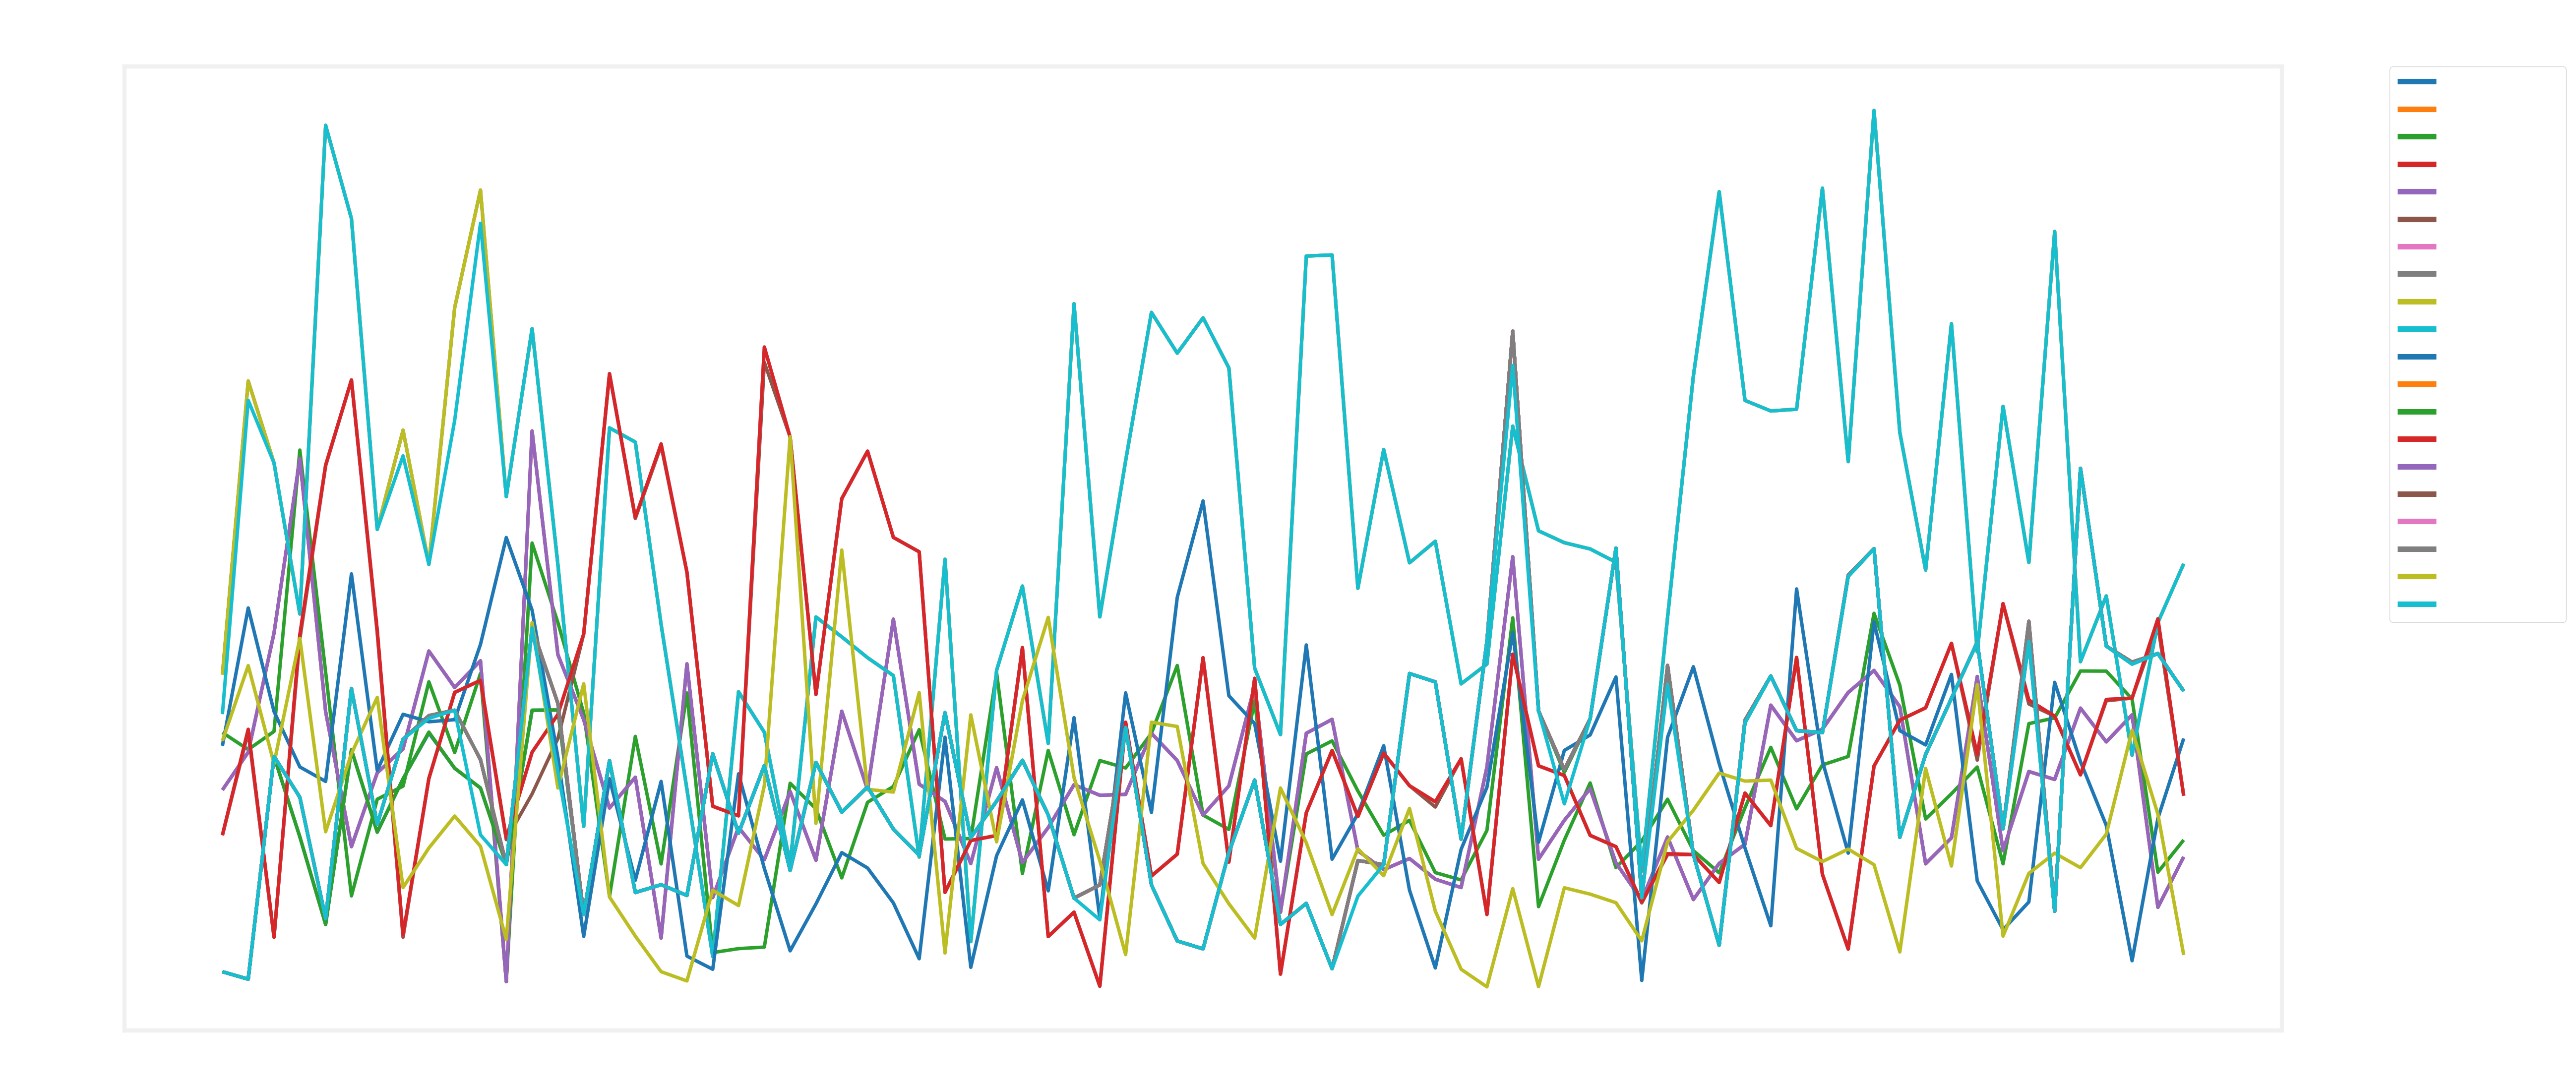

In [21]:
# plot the most popular 20 pipes throughout the given time period
# configure_matplotlib(tick_major_pad=20)
# fig, ax = plt.subplots(figsize=(25, 12))
# sns.lineplot(data=filled_df, palette="tab10", linewidth=2.5, ax=ax, dashes=False)
# plt.ylabel("Quantity")
# plt.title("Top 20 Pipes in 2022-2023")
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

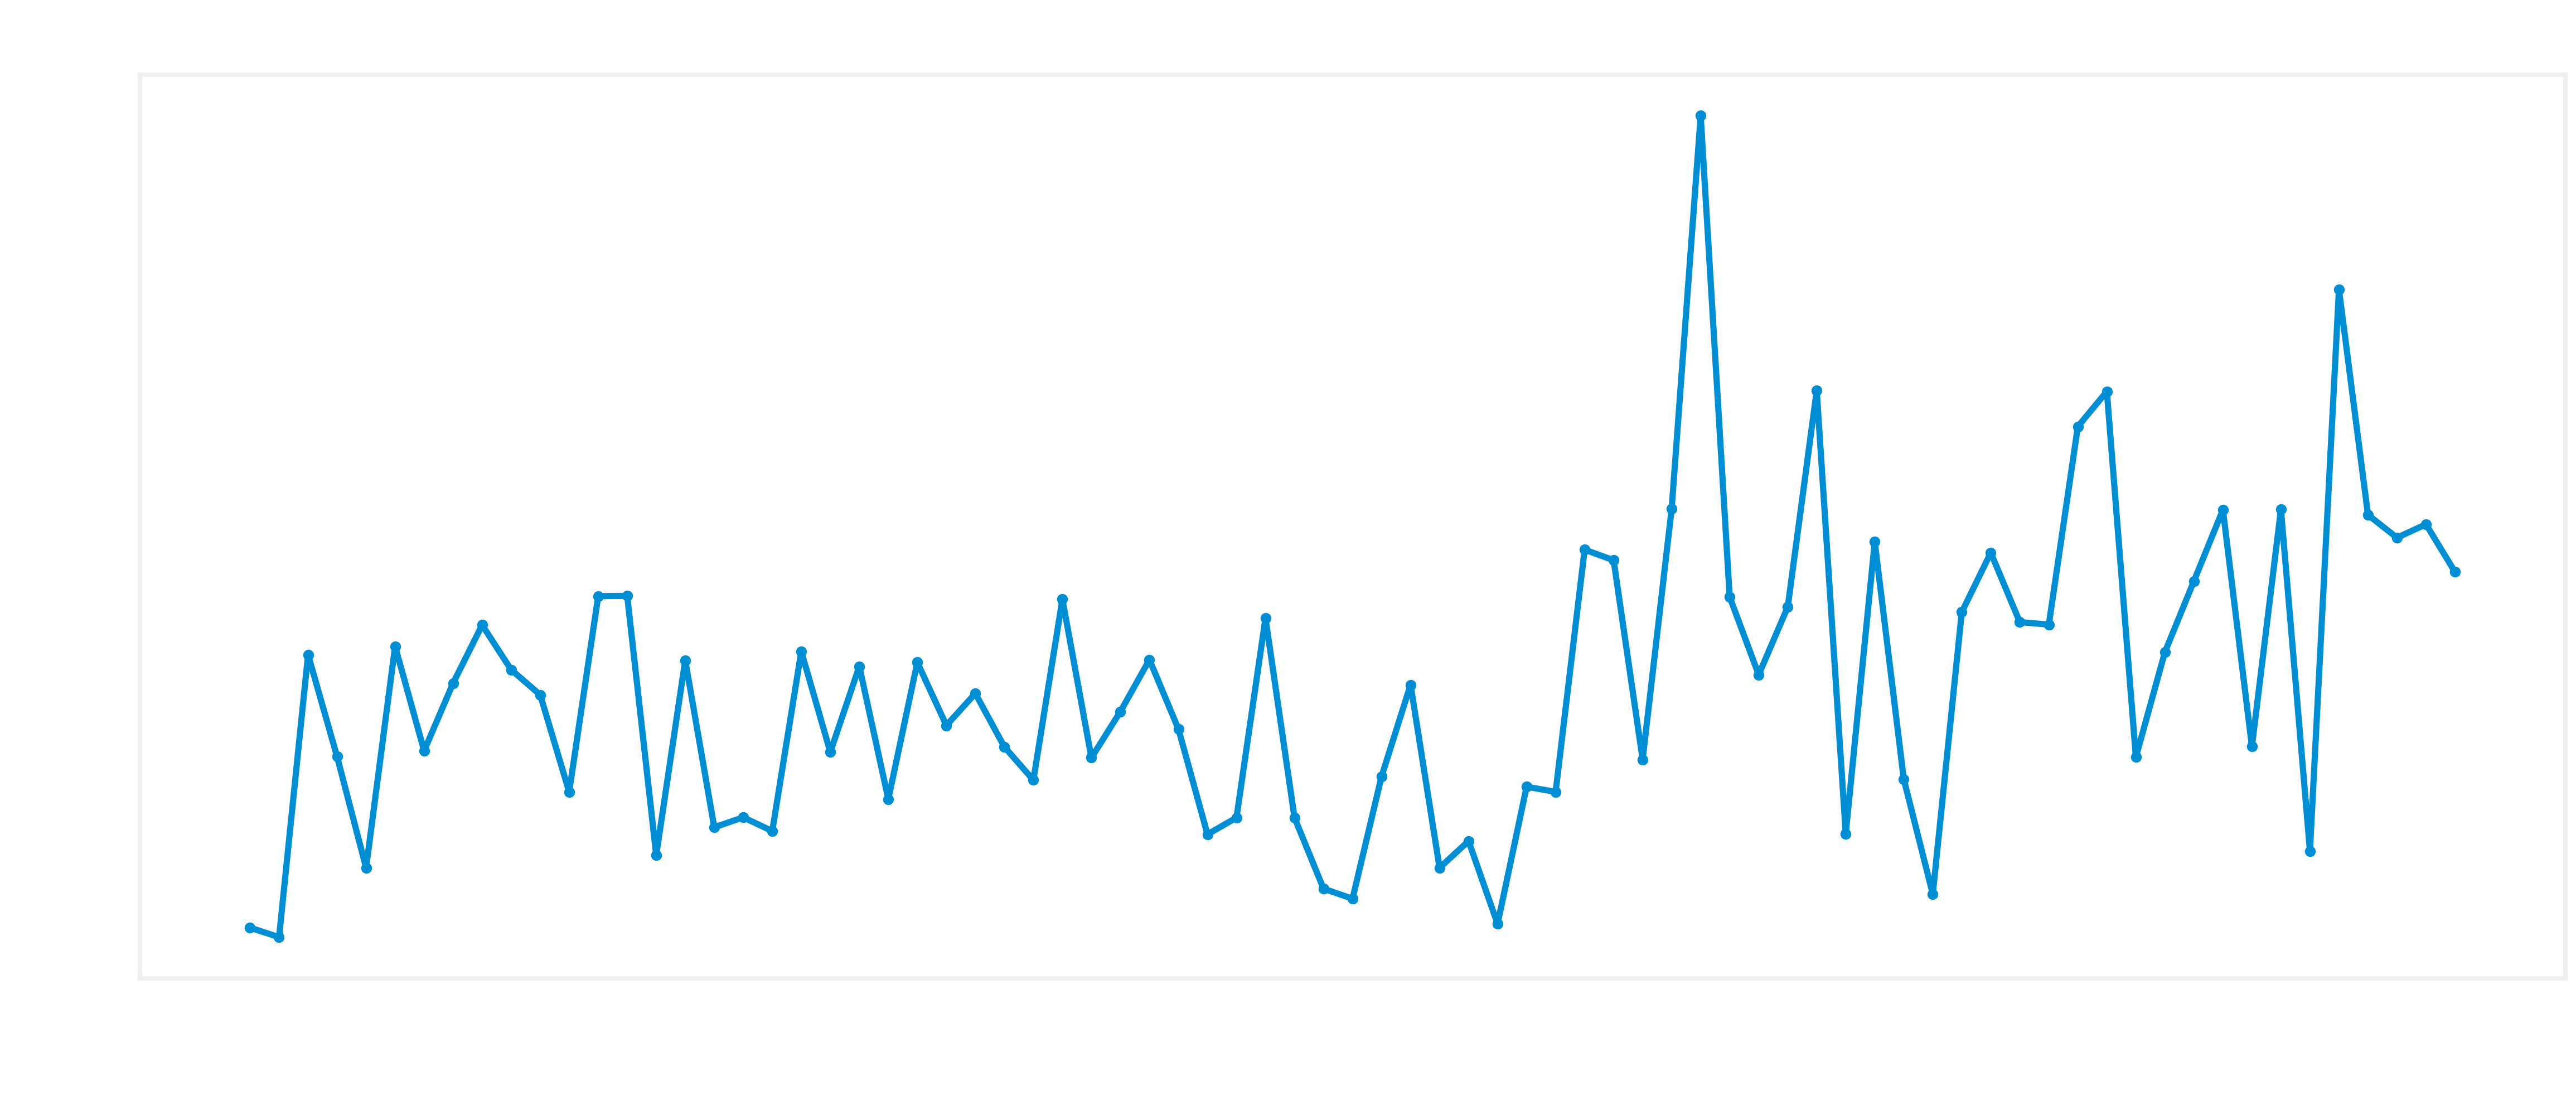

In [22]:
# configure_matplotlib(tick_major_pad=20)
# _, ax = plt.subplots(figsize=(25, 10))
# selected_pipe = filled_df.columns[0]
# plt.plot(filled_df[selected_pipe], marker='o')
# plt.xticks(rotation=90)
# plt.ylabel("Quantity")
# plt.title(f"Pipe TTNr: {filled_df.columns[0]}")
# plt.show()

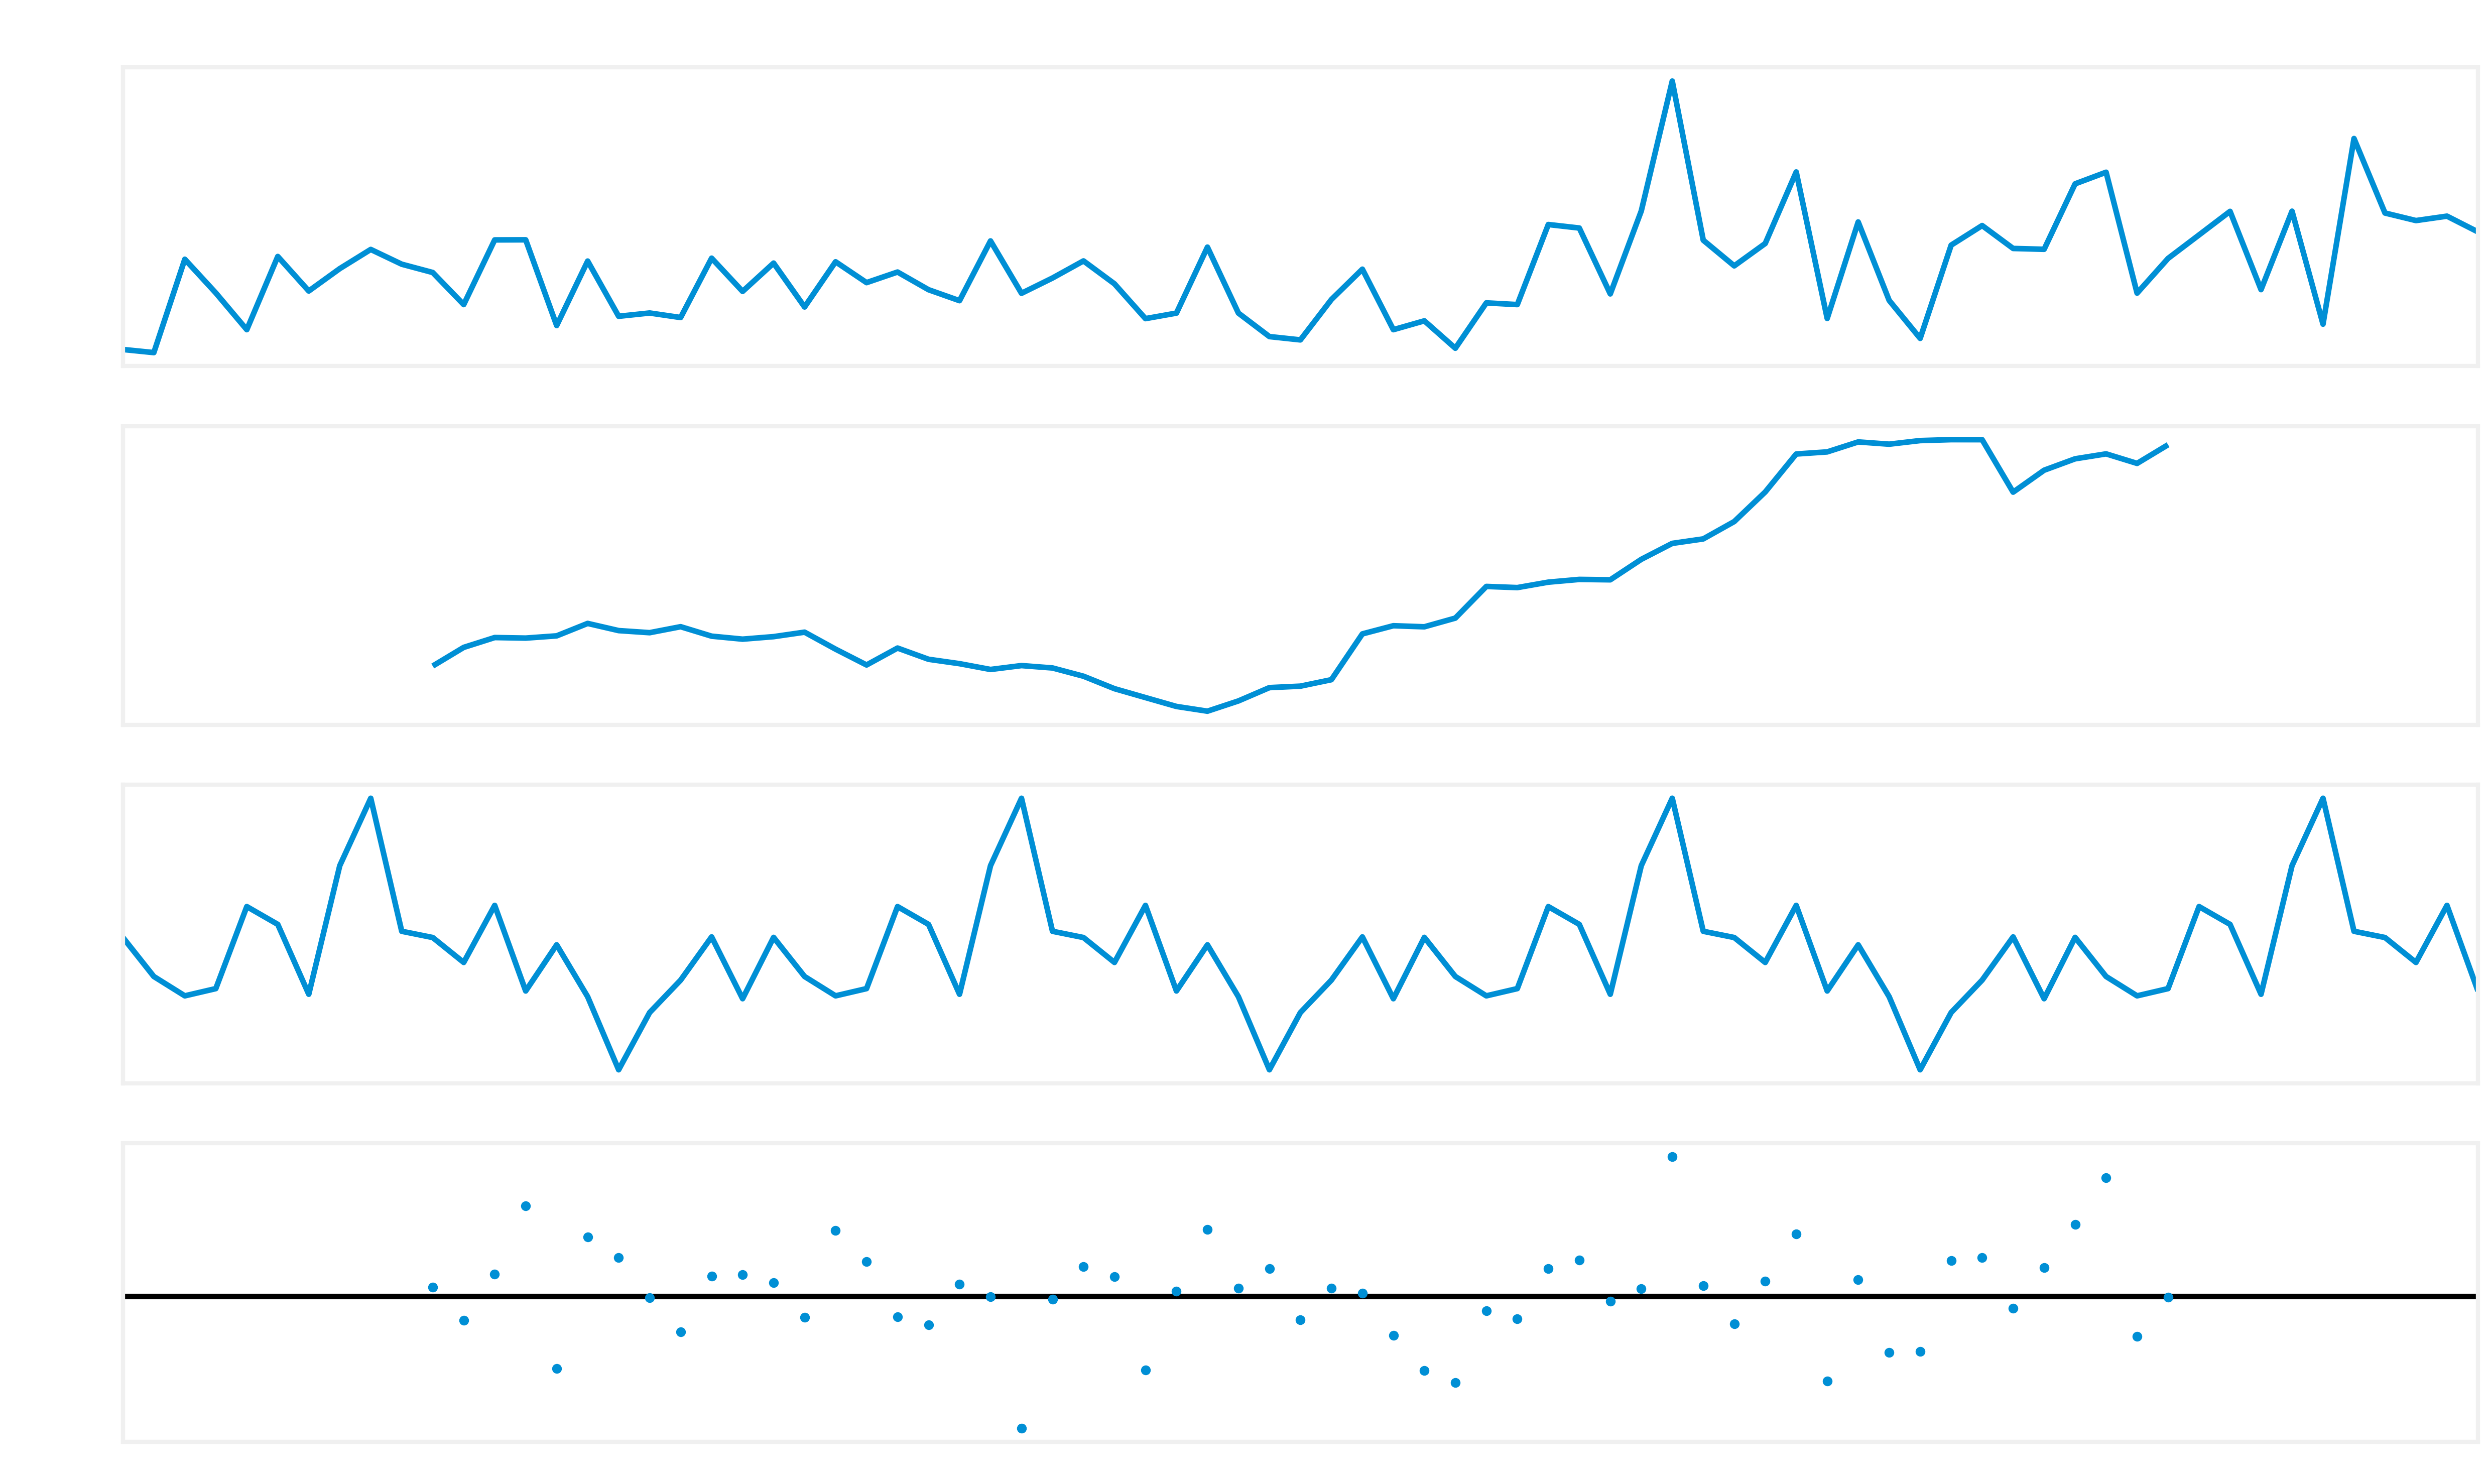

In [23]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # plot seasonal, trend, and residual components of the time series 
# decomposition = seasonal_decompose(filled_df[selected_pipe], model='additive', period=21)

# configure_matplotlib()
# decompose_fig = decomposition.plot()
# decompose_fig.set_size_inches(25, 15)
# decompose_fig.tight_layout()
# plt.show()

In [961]:
import tensorflow.python.keras.backend as K
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    

def create_lstm_model(train: pd.Series,
                      test: pd.Series,
                      activation: str = 'relu',
                      epoch: int = 100,
                      unit: int = 50,
                      drop_out: float = 0.2,
                      learning_rate: float = 0.01,
                      momentum: tuple[float, float] = (0.9, 0.999),
                      patience: int = 1) -> Any:
        # reshape the copy of the data
        train_data = train.copy().values.reshape(-1, 1)
        test_data = test.copy().values.reshape(-1, 1)

        # set the random seed
        tf.keras.utils.set_random_seed(42)

        # create the model
        model = Sequential()
        model.add(LSTM(unit, activation=activation, input_shape=(None, 1), return_sequences=False))
        model.add(Dropout(drop_out))
        model.add(Dense(1, activation=activation))
        adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=momentum[0], beta_2=momentum[1], amsgrad=False)
        model.compile(optimizer=adam, loss=root_mean_squared_error)

        es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=patience)
        mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

        # fit the model
        history = model.fit(train_data, train_data, epochs=epoch, verbose=0,
                                validation_data=(test_data, test_data), shuffle=False, callbacks=[es, mc])

        # make predictions
        predictions = model.predict(test_data, verbose=0)

        # calculate the rmse
        rmse = np.sqrt(mean_squared_error(test_data, predictions))

        # train rmse
        # train_predictions = model.predict(train_data, verbose=0)
        # train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))

        # calculate the loss
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        return predictions, rmse, test_data, train_loss, val_loss, model, es.stopped_epoch

In [1016]:
def format_time_series_df(master_df: pd.DataFrame) -> pd.DataFrame:
    """
    Format the index column of the dataframe according to time-series guidelines

    Args:
        master_df: The dataframe to be used as a reference

    Returns:
        A formatted dataframe (time-series) with periods as the index
    """
    df = master_df.copy()

    # reindex the all_in_one_T 
    if selected_years == [2022, 2023]:
        df.index = pd.date_range(start='2022-01-06', periods=len(master_df), freq='W')    
    else:
        # df.index = pd.date_range(start='2021-06-23', periods=len(master_df), freq='W')
        df.index = pd.date_range(end='2023-03-05', periods=len(master_df), freq='W')    

    # convert the index column to datetime
    df.index = df.index.astype('datetime64[ns]')

    # convert the index column to a period
    df.index = pd.DatetimeIndex(df.index).to_period('W')

    return df

In [1017]:
from tqdm import tqdm

range_index = (0, 20)
rmse_list, pipe_numbers = [], []
predictions, actual = [], []
loss, models = {}, {}

for i in tqdm(range(*range_index), ncols=100, bar_format="{l_bar}{bar:50}{r_bar}"):
    # format the train and test data to be used in the model
    formatted_df = format_time_series_df(master_df=all_in_one_T)
    pipe_number, train, test = select_pipe_and_split_data(data=formatted_df,
                                                          pipe_index=i,
                                                          is_sklearn=True,
                                                          test_size=0.1)

    pipe_numbers.append(pipe_number)
    actual.append(test)

    # convert index to datetime
    test.index = test.index.strftime('%Y-%m-%d')

    # compare LSTM with actual values
    # ax = plt.subplot(ceil(range_index[1] / 2), 2, i + 1)

    # ax.figure.set_size_inches(30, i * 6)

    # # plot the actual values
    # ax.set_title(f"Pipe TTNr: {pipe_number}")
    # ax.plot(test, marker='o')

    # ax.set_xticks(range(len(test.index)), test.index)

    # create and run the LSTM model
    prediction, lstm_rmse, lstm_test, train_loss, val_loss, model, stopped_epoch = create_lstm_model(
        train=train,
        test=test,
        activation='relu',
        epoch=100,
        unit=len(formatted_df.index) - 10,
        learning_rate=0.001,
        patience=5)

    print(f"Pipe TTNr: {pipe_number}\nStopped epoch: {stopped_epoch}\nRMSE: {lstm_rmse:.2f}\n")

    models[pipe_number] = model
    
    # store the loss values for every pipe
    loss[pipe_number] = {"train_loss": train_loss,
                         "val_loss": val_loss}

    rmse_list.append(lstm_rmse)
    predictions.append(prediction)

    # plot predictions
    # ax.set_title(f"Pipe TTNr: {pipe_number}\n LSTM: {lstm_rmse:.2f}")
    # ax.plot(prediction, marker='o')
    # ax.set_xticks(range(len(test.index)), test.index)
    # ax.legend(["Actual", "LSTM"], loc="upper right")

    # add vertical spacing between the subplots
#     plt.subplots_adjust(hspace=0.3, wspace=0.1)

# plt.show()

  0%|                                                  | 0/20 [00:00<?, ?it/s]2023-05-03 22:21:34.746587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:21:37.385999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:21:44.968777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
  5%|██▌                                               | 1/20 [00:11<03:46, 11.90s/it]

Pipe TTNr: 8705902546
Stopped epoch: 55
RMSE: 221.12



2023-05-03 22:21:45.837019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:21:48.069686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:21:56.706896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 10%|█████                                             | 2/20 [00:23<03:33, 11.87s/it]

Pipe TTNr: 8716113919
Stopped epoch: 55
RMSE: 217.94



2023-05-03 22:21:57.829991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:00.608267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:22:08.452647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 15%|███████▌                                          | 3/20 [00:35<03:20, 11.77s/it]

Pipe TTNr: 8718640762
Stopped epoch: 55
RMSE: 139.84



2023-05-03 22:22:09.505675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:11.780979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:22:19.336658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 20%|██████████                                        | 4/20 [00:46<03:02, 11.41s/it]

Pipe TTNr: 8718640763
Stopped epoch: 55
RMSE: 110.15



2023-05-03 22:22:20.259054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:22.495283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:22:30.444719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 25%|████████████▌                                     | 5/20 [00:57<02:49, 11.31s/it]

Pipe TTNr: 8718640787
Stopped epoch: 55
RMSE: 110.15



2023-05-03 22:22:31.466976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:33.721275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:22:41.180525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 30%|███████████████                                   | 6/20 [01:08<02:35, 11.11s/it]

Pipe TTNr: 8718645319
Stopped epoch: 55
RMSE: 122.13



2023-05-03 22:22:42.050156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:44.432320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:22:52.445811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 35%|█████████████████▌                                | 7/20 [01:19<02:25, 11.17s/it]

Pipe TTNr: 8718647378
Stopped epoch: 55
RMSE: 121.42



2023-05-03 22:22:55.160463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:22:57.631725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00091: early stopping


2023-05-03 22:23:07.608570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 40%|████████████████████                              | 8/20 [01:34<02:29, 12.44s/it]

Pipe TTNr: 8718649158
Stopped epoch: 90
RMSE: 332.93



2023-05-03 22:23:08.590324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:23:10.987094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00091: early stopping


2023-05-03 22:23:21.505736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 45%|██████████████████████▌                           | 9/20 [01:48<02:22, 12.91s/it]

Pipe TTNr: 8718649167
Stopped epoch: 90
RMSE: 332.93



2023-05-03 22:23:22.545846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:23:24.864248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00091: early stopping


2023-05-03 22:23:34.926975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 50%|█████████████████████████                         | 10/20 [02:01<02:10, 13.06s/it]

Pipe TTNr: 8718649588
Stopped epoch: 90
RMSE: 335.09



2023-05-03 22:23:35.946227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:23:38.209429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00053: early stopping


2023-05-03 22:23:45.421666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 55%|███████████████████████████▌                      | 11/20 [02:12<01:50, 12.27s/it]

Pipe TTNr: 8718649589
Stopped epoch: 52
RMSE: 86.32



2023-05-03 22:23:46.278327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:23:48.390092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:23:55.895018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 60%|██████████████████████████████                    | 12/20 [02:22<01:33, 11.73s/it]

Pipe TTNr: 8718651804
Stopped epoch: 55
RMSE: 219.43



2023-05-03 22:23:56.812345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:23:59.099384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:24:06.807752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 65%|████████████████████████████████▌                 | 13/20 [02:33<01:20, 11.49s/it]

Pipe TTNr: 8718653366
Stopped epoch: 55
RMSE: 222.62



2023-05-03 22:24:07.808449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:24:10.036341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:24:17.697648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 70%|███████████████████████████████████               | 14/20 [02:44<01:07, 11.29s/it]

Pipe TTNr: 8718654166
Stopped epoch: 55
RMSE: 121.42



2023-05-03 22:24:18.569591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:24:20.726801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:24:28.286577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 75%|█████████████████████████████████████▌            | 15/20 [02:55<00:55, 11.09s/it]

Pipe TTNr: 8718696020
Stopped epoch: 55
RMSE: 219.43



2023-05-03 22:24:29.215075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:24:31.381052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:24:39.142571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 80%|████████████████████████████████████████          | 16/20 [03:06<00:44, 11.03s/it]

Pipe TTNr: 8718696337
Stopped epoch: 55
RMSE: 219.43



2023-05-03 22:24:40.568323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:24:43.220093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:24:50.959035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 85%|██████████████████████████████████████████▌       | 17/20 [03:17<00:33, 11.26s/it]

Pipe TTNr: 8718698387
Stopped epoch: 55
RMSE: 219.43



2023-05-03 22:24:51.983605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:24:54.470369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:25:02.328358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 90%|█████████████████████████████████████████████     | 18/20 [03:29<00:22, 11.29s/it]

Pipe TTNr: 8718699250
Stopped epoch: 55
RMSE: 219.43



2023-05-03 22:25:03.333339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:25:05.713581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00047: early stopping


2023-05-03 22:25:12.949835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
 95%|███████████████████████████████████████████████▌  | 19/20 [03:39<00:11, 11.10s/it]

Pipe TTNr: 8719905826
Stopped epoch: 46
RMSE: 97.63



2023-05-03 22:25:13.990656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-03 22:25:16.415748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 00056: early stopping


2023-05-03 22:25:24.580760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
100%|██████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.59s/it]

Pipe TTNr: 8750306523
Stopped epoch: 55
RMSE: 219.29



In [1018]:
# plot the train_loss and val_loss for every pipe
for i in range(*range_index):
    ax = plt.subplot(ceil(range_index[1] / 2), 2, i + 1)
    ax.figure.set_size_inches(30, i * 6)

    ax.plot(loss[pipe_numbers[i]]["train_loss"])
    ax.plot(loss[pipe_numbers[i]]["val_loss"])
    ax.set_title(f"Pipe TTNr: {pipe_numbers[i]}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(["train", "validation"], loc="upper right")
    plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()

In [1019]:
pipe_indexes = []
for i in range(len(actual)):
    pipe_indexes.append(actual[i].name)

top_20_df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], codes=[[], []]), columns=[])
top_20_df.index = pd.MultiIndex.from_product([pipe_numbers, actual[0].index], names=['Pipe TTNr', 'Date'])

In [1020]:
top_20_df['Actual'] = np.concatenate(actual)
top_20_df['Prediction'] = np.concatenate(predictions)

In [1021]:
top_20_df.index.levels[1]

Index(['2023-01-15', '2023-01-22', '2023-01-29', '2023-02-05', '2023-02-12',
       '2023-02-19', '2023-02-26', '2023-03-05'],
      dtype='object', name='Date')

In [1022]:
top_20_df.head()

Actual   Prediction
Pipe TTNr  Date                           
8705902546 2023-01-15  1470.0  1361.107788
           2023-01-22  3174.0  2938.092529
           2023-01-29   720.0   666.903931
           2023-02-05  4752.0  4398.469727
           2023-02-12  3134.0  2901.074463

In [1023]:
def get_top_20(selected_date: str, df: pd.DataFrame = top_20_df, lstm_only: bool = True) -> pd.DataFrame:
    if selected_date not in df.index.levels[1]:
        raise ValueError(f"Date {selected_date} is not in the index")
    else:
        selected_df = df.copy().loc[(slice(None), selected_date), :]
        selected_df = selected_df.copy().sort_values(by='Prediction', ascending=False, inplace=False)
        if lstm_only:
            lstm_only_df = selected_df.copy().loc[:, ['Prediction']]
            lstm_only_df.index = lstm_only_df.index.droplevel(1)
            lstm_only_df['Pipe TTNr'] = lstm_only_df.index
            lstm_only_df.index = range(1, len(lstm_only_df) + 1)
            lstm_only_df = lstm_only_df.copy().loc[:, ['Pipe TTNr', 'Prediction']]
            lstm_only_df.index.name = selected_date
            return lstm_only_df
        else:
            selected_df = selected_df.copy().loc[:, ['Actual', 'Prediction']]
            selected_df.index = selected_df.index.droplevel(1)
            selected_df['Pipe TTNr'] = selected_df.index
            selected_df.index = range(1, len(selected_df) + 1)
            selected_df = selected_df.copy().loc[:, ['Pipe TTNr', 'Actual', 'Prediction']]
            selected_df.index.name = selected_date
            return selected_df

In [1024]:
predicted_df = get_top_20('2023-03-05', lstm_only=False)
predicted_df

Pipe TTNr  Actual   Prediction
2023-03-05                                 
1           8718649158  3883.0  3578.284912
2           8718649167  3883.0  3578.284912
3           8718649588  3883.0  3576.304443
4           8718651804  2724.0  2525.037842
5           8718699250  2724.0  2525.037842
6           8718698387  2724.0  2525.037842
7           8718696337  2724.0  2525.037842
8           8718696020  2724.0  2525.037842
9           8716113919  2724.0  2525.018555
10          8750306523  2724.0  2523.313721
11          8718653366  2724.0  2521.656250
12          8705902546  2724.0  2521.635498
13          8718649589  2293.0  2176.908691
14          8718647378  1772.0  1692.424805
15          8718654166  1772.0  1692.424805
16          8718645319  1772.0  1691.498047
17          8718640762  1369.0  1284.396362
18          8718640787  1215.0  1147.883423
19          8718640763  1215.0  1147.883423
20          8719905826   322.0   298.038055

In [1248]:
cnt = 0

# convert formatted_df index from period to datetime
test_df = formatted_df.copy()
test_df.index = test_df.index.to_timestamp(how="S", freq="W")

In [1249]:
# test_df

In [1250]:
def forecast_future_weeks(forecast_pipe_index: int = 1,
                          num_prediction: int = 1,
                          df: pd.DataFrame = test_df,
                          look_back: int = 7):
    
    forecast_pipe_index = forecast_pipe_index
    forecasted_pipe = pipe_numbers[forecast_pipe_index]
    num_prediction = num_prediction

    # get the last 7 weeks of the pipe
    last_7_days = df.loc[:, forecasted_pipe].iloc[-look_back:]

    # convert the last 7 weeks to a numpy array
    last_7_days = np.array(last_7_days)

    # reshape the array to be used in the model
    last_7_days = last_7_days.reshape((1, last_7_days.shape[0], 1))

    # # forecast the next 7 days
    forecast = models[forecasted_pipe].predict(last_7_days)

    # convert the forecasted values to a dataframe
    forecast_df = pd.DataFrame(forecast)
    forecast_df.index = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=num_prediction, freq='W')
    forecast_df.columns = [forecasted_pipe]

    return forecast_df

In [1267]:
added_df = pd.DataFrame()

for i in range(len(pipe_numbers)):
    added_df = pd.concat([added_df, forecast_future_weeks(forecast_pipe_index=i, num_prediction=1, df=test_df, look_back=7 + cnt * 5)], axis=1)

1/1 [==============================] - 0s 80ms/step


In [1268]:
if added_df.index.values.astype(np.datetime64) not in list(test_df.index.values):
    test_df = pd.concat([test_df, added_df], axis=0, ignore_index=False)
    cnt += 1

In [1269]:
test_df = test_df.round(1)
test_df.tail(cnt)

8705902546  8716113919  8718640762  8718640763  8718640787  \
2023-03-12      3670.0      3715.7      3661.3      3010.4      3010.4   
2023-03-19      2079.6      2107.3      4748.2      2112.8      2112.8   
2023-03-26      2281.8      4059.6      6727.1       881.6       881.6   
2023-04-02      1292.6         0.0     10169.9      5393.1      5393.1   
2023-04-09      4713.8         0.0      6569.8      2699.2      2699.2   

            8718645319  8718647378  8718649158  8718649167  8718649588  \
2023-03-12      7864.0      6631.5      9515.2      9515.2      9584.7   
2023-03-19      9251.9      6272.0     19127.6     19127.6     19085.6   
2023-03-26     13957.2      6589.1     30024.4     30024.4     30324.4   
2023-04-02     11789.8      4016.2      7330.5      7330.5     35950.2   
2023-04-09      9707.2       229.4     36294.6     36294.6     43143.3   

            8718649589  8718651804  8718653366  8718654166  8718696020  \
2023-03-12      2366.3      4407.1      3734.5      6631.5      4407.1   
2023-03-19       831.2      3683.7      3207.8      6272.0      3683.7   
2023-03-26      2477.9      5615.4       869.7      6589.1      5615.4   
2023-04-02      2214.3         0.0      2475.3      4016.2         0.0   
2023-04-09       758.4         0.0      5119.1       229.4         0.0   

            8718696337  8718698387  8718699250  8719905826  8750306523  
2023-03-12      4407.1      4407.1      4407.1      2242.6      3660.8  
2023-03-19      3683.7      3683.7      3683.7      1854.3      2834.9  
2023-03-26      5615.4      5615.4      5615.4      1856.8      4901.8  
2023-04-02         0.0         0.0         0.0      1088.2      1854.5  
2023-04-09         0.0         0.0         0.0      1595.2      5534.0

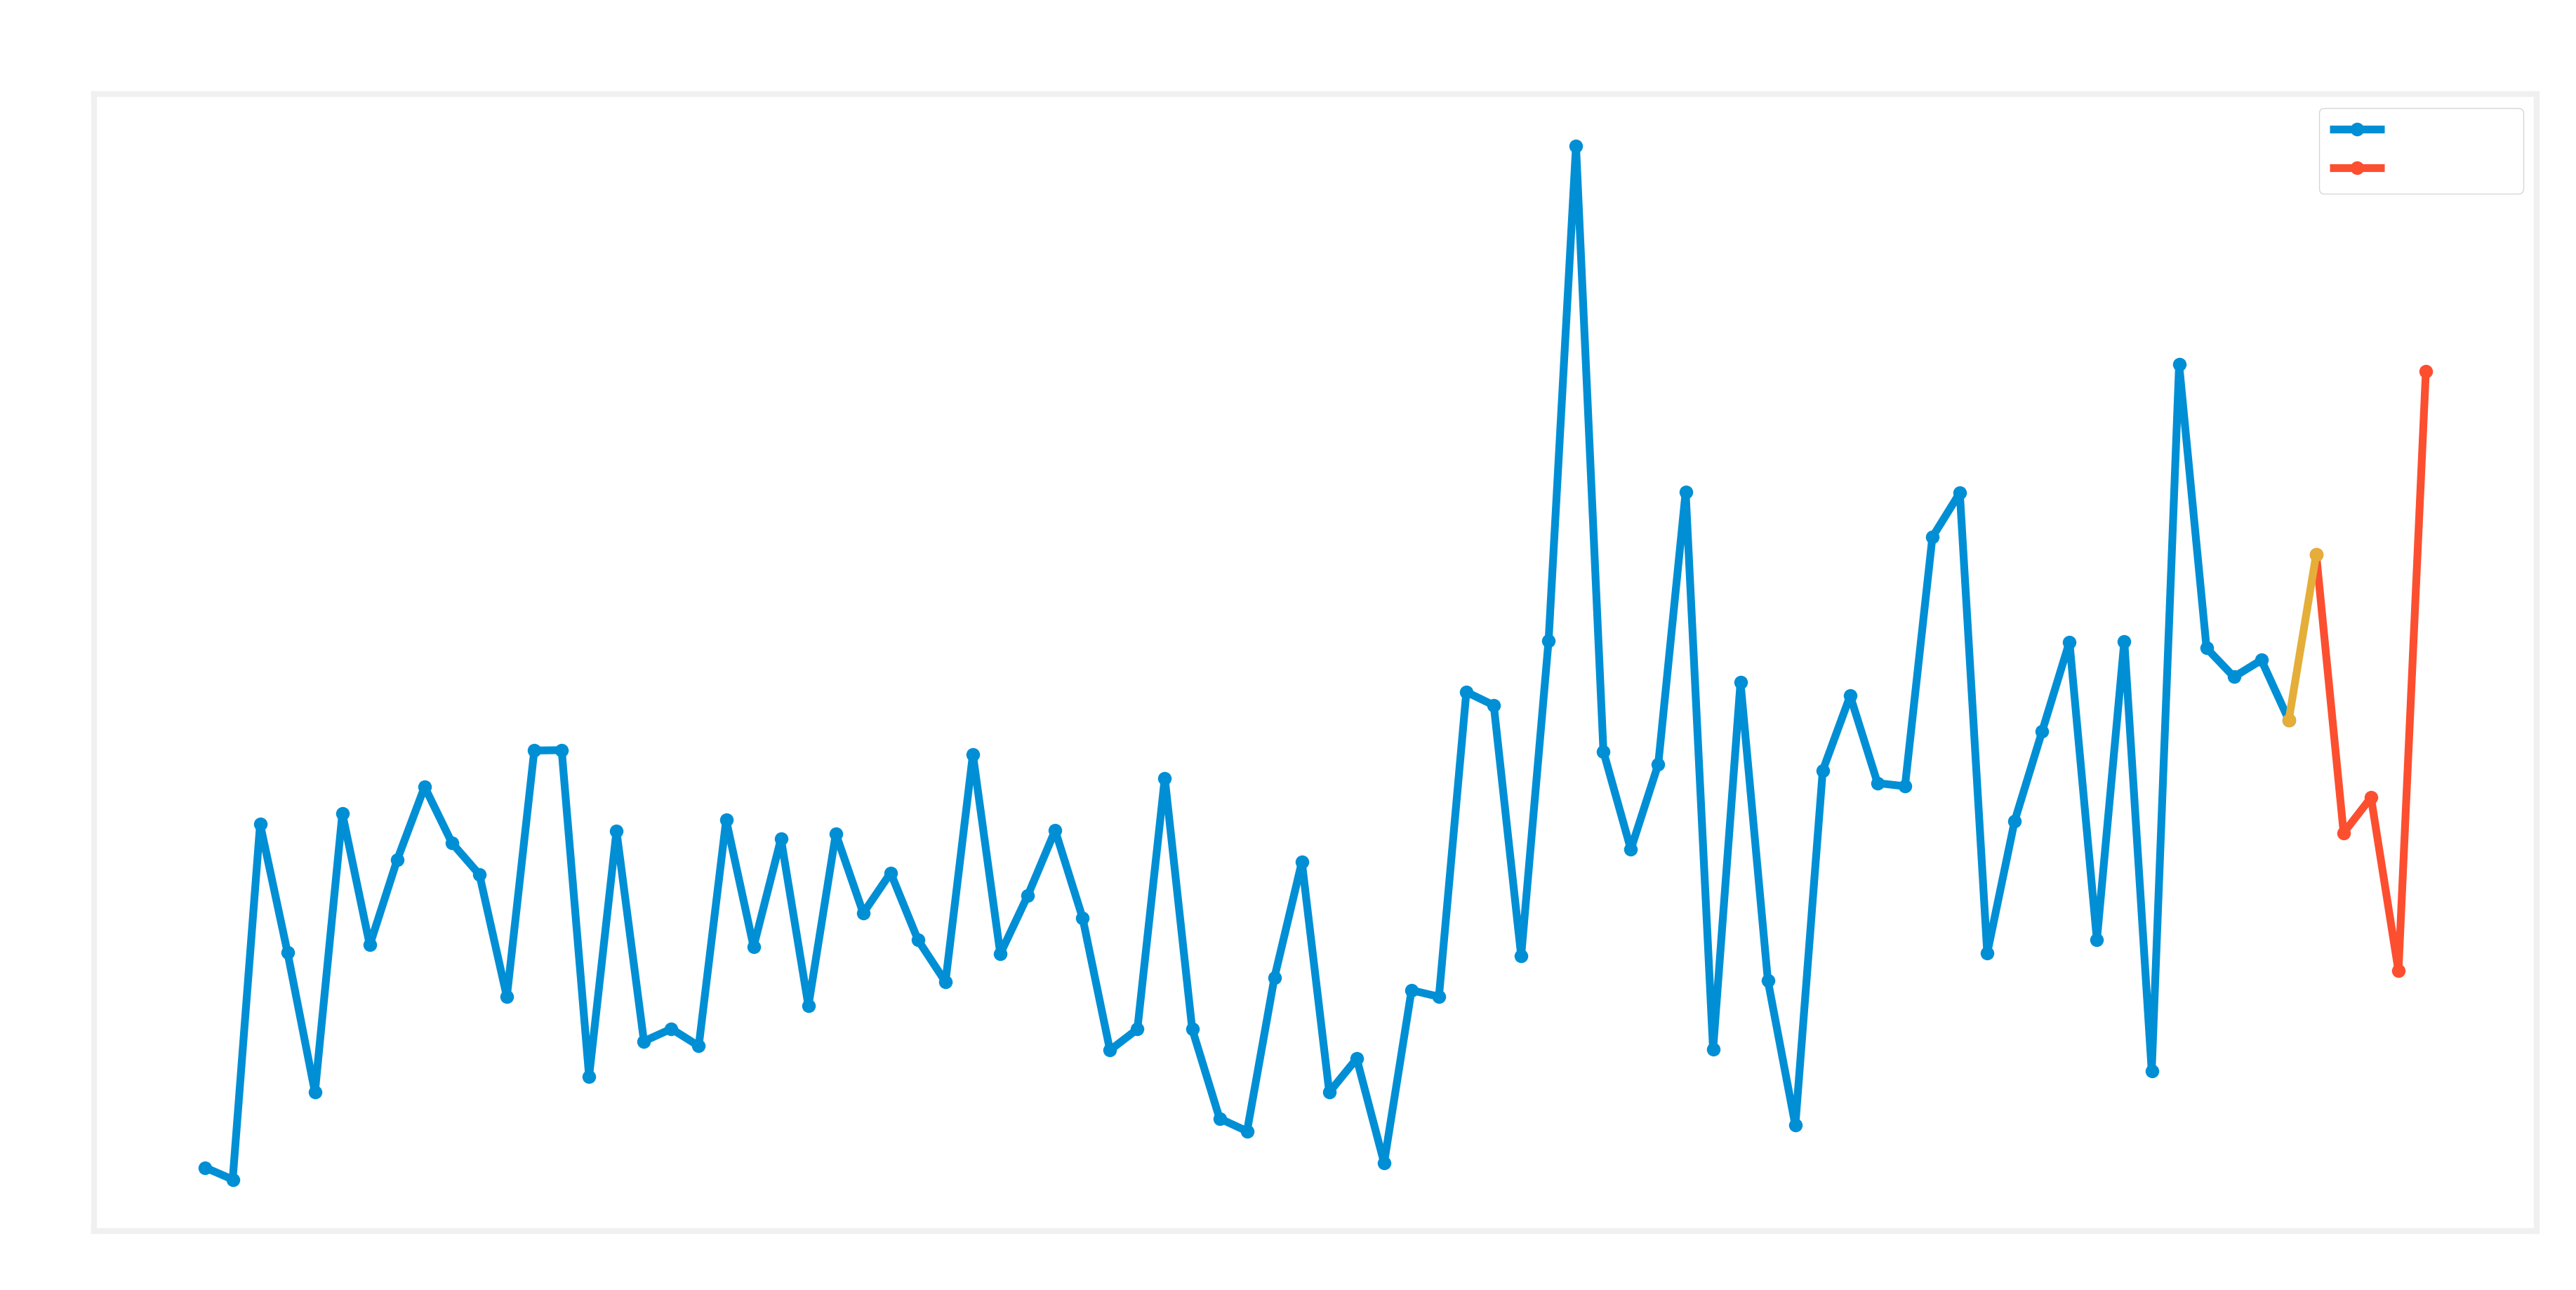

In [1271]:
# plot the time-series for the first column of test_df and added_df
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(test_df.iloc[:-cnt, 0], marker='o')
ax.plot(test_df.iloc[-cnt:, 0], marker='o')
ax.plot([test_df.index[-cnt - 1], test_df.index[-cnt]], [test_df.iloc[-cnt - 1, 0], test_df.iloc[-cnt, 0]], marker='o')
ax.set_title(f"Pipe TTNr: {pipe_numbers[0]}")
ax.legend(["Actual", "Forecast"], loc="upper right")
plt.show()

In [1199]:
save_df = test_df.tail(1).T.sort_values(by=test_df.tail(1).index[0], ascending=False)
save_df['Pipe TTNr'] = save_df.index
save_df.index = range(1, len(save_df) + 1)
save_df.index.name = save_df.columns[0]
save_df.columns = ['Prediction', 'Pipe TTNr']
save_df

Prediction   Pipe TTNr
2023-03-12 00:00:00                        
1                        9584.7  8718649588
2                        9515.2  8718649158
3                        9515.2  8718649167
4                        7864.0  8718645319
5                        6631.5  8718647378
6                        6631.5  8718654166
7                        4407.1  8718696337
8                        4407.1  8718699250
9                        4407.1  8718698387
10                       4407.1  8718651804
11                       4407.1  8718696020
12                       3734.5  8718653366
13                       3715.7  8716113919
14                       3670.0  8705902546
15                       3661.3  8718640762
16                       3660.8  8750306523
17                       3010.4  8718640787
18                       3010.4  8718640763
19                       2366.3  8718649589
20                       2242.6  8719905826

In [ ]:
# write test_df.tail(1) to excel file
# save_dir = "/Users/ozansahin/Documents/GitHub/Bosch-Data-Analysis/"
# save_df.to_excel(f"{save_dir}forecast_2023_w10.xlsx")